# Planejamento da solução

-- Objetivo do problema: Previsão do primeiro destino que um novo usuário irá escolher

- Porque?
    - Qual tipo de modelo de negócio do Airbnb?
        - Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        - Oferta ( pessoas oferecendo acomodacao )
            - Tamanho do portfólio.
            - Diversidade/Densidade de Portfólio.
            - Preco Medio
            
        - Demanda ( pessoas procurando acomodacao )
            - Numero de Usuários
            - LTV ( Lifetime Value )
            - CAC ( Client Acquisition Cost )
            
           Gross Revenue = ( Fee*Numero cliente ) - CAC 

#
-- Proposta da Solucao
- Modelo de Predivao do primeiro destino de um novo usario.
- 1.0. Predicoes e salva em tabela do banco de dados. 
- 2.0. API 
    - Input: usuario e suas caracteristicas
    - Output: usuario e suas caracteristicas com a **predicao do destino**
        
--- Esperado 16 ciclos

# 0.0 Imports

In [1]:
import random
import pickle
import numpy    as np
import pandas   as pd
import seaborn  as sns

from matplotlib import pyplot as plt
from pycorrcat  import pycorrcat
from pandas_profiling import ProfileReport

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as me
from scikitplot import metrics         as mt
from imblearn   import combine

from keras      import models as ml
from keras      import layers as la
from lightgbm   import LGBMClassifier

f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22, 12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignora future warnings
    #warnings.filterwarnings('ignore')
    
    sns.set()
    

In [3]:
jupyter_settings()

## 0.2 Load Data

In [4]:
df_raw = pd.read_csv('../data/raw/train_users_2.csv', low_memory=False)
df_sessions = pd.read_csv('../data/raw/sessions.csv', low_memory=False)

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 1.1 Data Dimension

In [6]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of cols: {df1.shape[1]}')

number of rows: 213451
number of cols: 16


In [7]:
print(f'number of rows: {df_sessions.shape[0]}')
print(f'number of cols: {df_sessions.shape[1]}')

number of rows: 10567737
number of cols: 6


## 1.2 Data Types

In [8]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [9]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 Check NA

In [10]:
df1.isna().sum() / len(df1)

id                        0.000
date_account_created      0.000
timestamp_first_active    0.000
date_first_booking        0.583
gender                    0.000
age                       0.412
signup_method             0.000
signup_flow               0.000
language                  0.000
affiliate_channel         0.000
affiliate_provider        0.000
first_affiliate_tracked   0.028
signup_app                0.000
first_device_type         0.000
first_browser             0.000
country_destination       0.000
dtype: float64

In [11]:
df_sessions.isna().sum() / len(df_sessions)

user_id         0.003
action          0.008
action_type     0.107
action_detail   0.107
device_type     0.000
secs_elapsed    0.013
dtype: float64

## 1.4 Replace NA

In [12]:
# ========== User =================
# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = df1['age'].astype('int64').mean()
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions =================
# user_id - 0.3% 
# # action - 0.7% 
# # action_type - 11% 
# # action_detail - 11% 
# # secs_elapsed - 1.2%
df_sessions = df_sessions.dropna()

In [13]:
df1.isna().sum() / len(df1)

id                        0.000
date_account_created      0.000
timestamp_first_active    0.000
date_first_booking        0.000
gender                    0.000
age                       0.000
signup_method             0.000
signup_flow               0.000
language                  0.000
affiliate_channel         0.000
affiliate_provider        0.000
first_affiliate_tracked   0.000
signup_app                0.000
first_device_type         0.000
first_browser             0.000
country_destination       0.000
dtype: float64

In [14]:
df_sessions.isna().sum() / len(df_sessions)

user_id         0.000
action          0.000
action_type     0.000
action_detail   0.000
device_type     0.000
secs_elapsed    0.000
dtype: float64

## 1.5 Change Types

In [15]:
 # date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( 'int64' )

In [16]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6 Check Balanced Data

In [17]:
df1['country_destination'].value_counts( normalize=True )

NDF     0.447
US      0.392
other   0.061
FR      0.030
IT      0.016
GB      0.014
ES      0.014
CA      0.009
DE      0.007
NL      0.005
AU      0.004
PT      0.001
Name: country_destination, dtype: float64

## 1.7 Descriptive Statistical

In [18]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop('user_id', axis=1)
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1 Numerical Attributes - Users

In [19]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
age,16.000,115.000,99.000,37.406,34.000,13.940,2.090,6.516
signup_flow,0.000,25.000,25.000,2.520,0.000,6.605,2.706,5.928


### 1.7.2 Numerical Attributes - Sessions

In [20]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes_sessions.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
secs_elapsed,0.000,1799977.000,1799977.000,19961.825,1369.000,88849.393,11.138,154.843


### 1.7.3 Categorical Attributes - Users

In [21]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.7.4 Categorical Attributes - Sessions

In [22]:
cat_attributes_sessions.describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


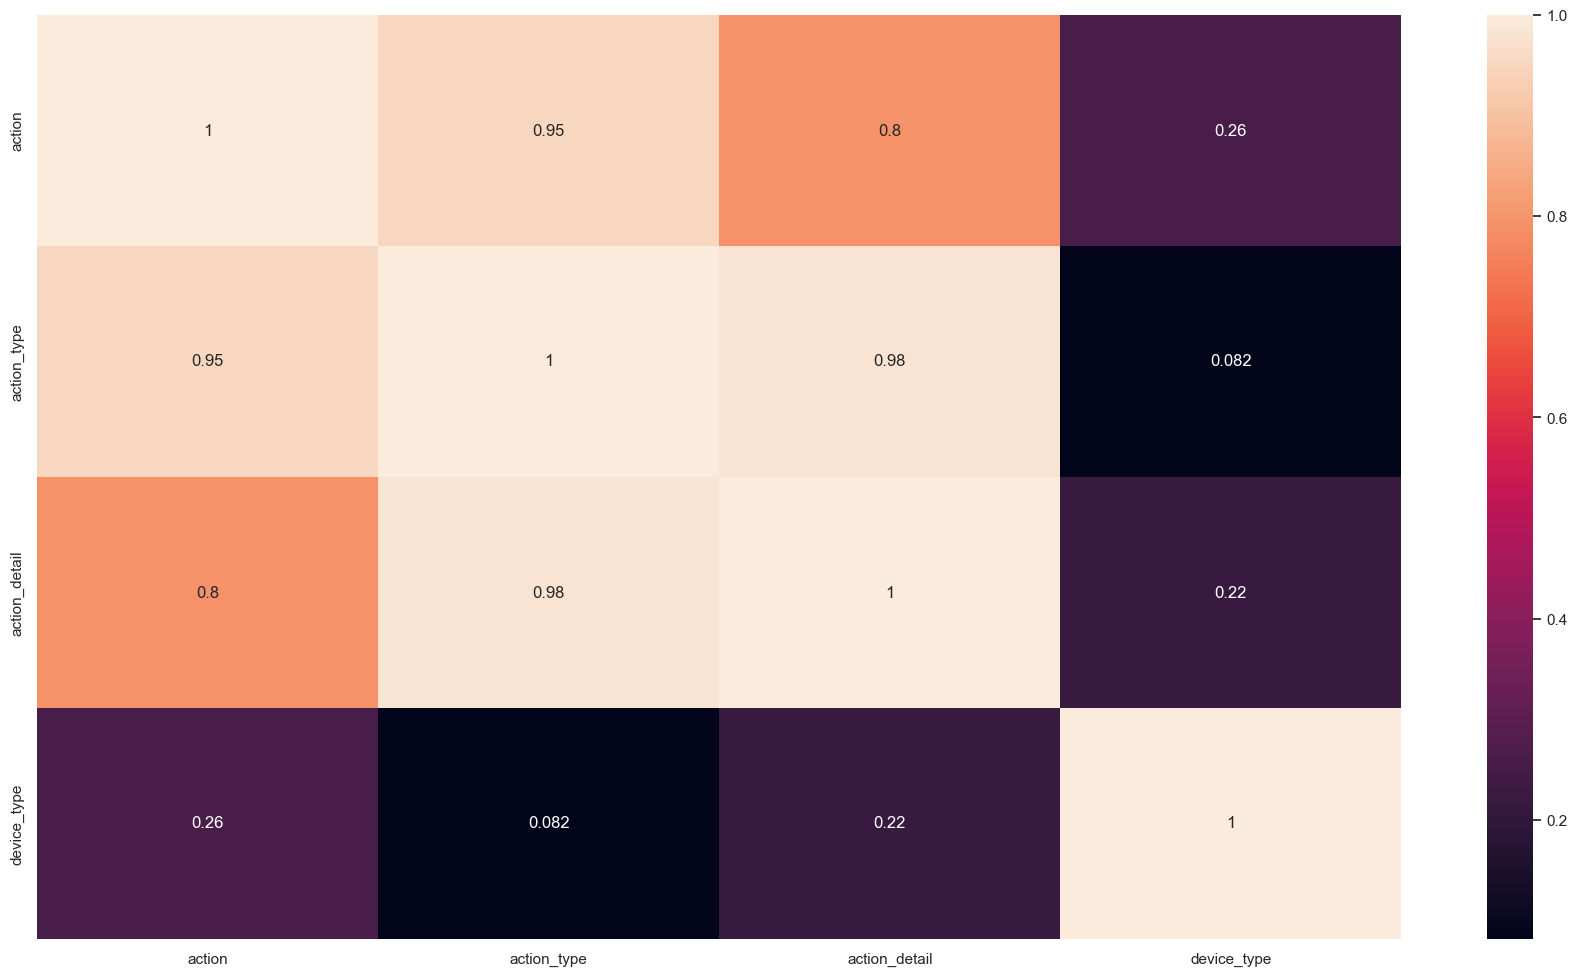

In [23]:
# Cramer V correlation
d = pycorrcat.corr_matrix(cat_attributes_sessions, ['action', 'action_type', 'action_detail', 'device_type'])
sns.heatmap(d, annot=True);

# 2.0 Data Filtering

In [24]:
df2 = df1.copy()

## 2.1. Filtering Rows

In [25]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df2 = df2[( df2['age'] > 15 ) & ( df2['age'] < 120 )]

## 2.2. Columns Selection

# 3.0 Feature Engineering

In [26]:
df3 = df2.copy()

In [27]:
 # days from first active up to first booking
df3['first_active'] = pd.to_datetime(df3['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df3['days_from_first_active_until_booking'] = (df3['date_first_booking'] - df3['first_active'] ).apply( lambda x: x.days )

# days from first active upt to account created
df3['days_from_first_active_until_account_created'] = (df3['date_account_created'] - df3['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df3['days_from_account_created_until_first_booking'] = (df3['date_first_booking'] - df3['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================
# year first active
df3['year_first_active'] = df3['first_active'].dt.year

# month first active
df3['month_first_active'] = df3['first_active'].dt.month

# day first active
df3['day_first_active'] = df3['first_active'].dt.day

# day of week first active
df3['day_of_week_first_active'] = df3['first_active'].dt.dayofweek

# week of year first active
df3['week_of_year_first_active'] = df3['first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df3['year_first_booking'] = df3['date_first_booking'].dt.year

# month first booking
df3['month_first_booking'] = df3['date_first_booking'].dt.month

# day first booking
df3['day_first_booking'] = df3['date_first_booking'].dt.day

# day of week first booking
df3['day_of_week_first_booking'] = df3['date_first_booking'].dt.dayofweek

# week of year first booking
df3['week_of_year_first_booking'] = df3['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df3['year_account_created'] = df3['date_account_created'].dt.year

# month  account_created
df3['month_account_created'] = df3['date_account_created'].dt.month

# day  account_created
df3['day_account_created'] = df3['date_account_created'].dt.day

# day of week  account_created
df3['day_of_week_account_created'] = df3['date_account_created'].dt.dayofweek

# week of year  account_created
df3['week_of_year_account_created'] = df3['date_account_created'].dt.weekofyear

C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_14192\3728402332.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_first_active'] = df3['first_active'].dt.weekofyear
C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_14192\3728402332.py:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_first_booking'] = df3['date_first_booking'].dt.weekofyear
C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_14192\3728402332.py:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_account_created'] = df3['date_account_created'].dt.weekofyear


In [28]:
df3.isna().sum()

id                                               0
date_account_created                             0
timestamp_first_active                           0
date_first_booking                               0
gender                                           0
age                                              0
signup_method                                    0
signup_flow                                      0
language                                         0
affiliate_channel                                0
affiliate_provider                               0
first_affiliate_tracked                          0
signup_app                                       0
first_device_type                                0
first_browser                                    0
country_destination                              0
first_active                                     0
days_from_first_active_until_booking             0
days_from_first_active_until_account_created     0
days_from_account_created_until

In [29]:
df3.shape

(122636, 35)

In [30]:
# Drop original datetime
cols = ['date_account_created', 'date_first_booking', 'timestamp_first_active', 'first_active']
df3 = df3.drop( cols, axis=1 )

# 4.0 Exploratory Data Analysis

In [31]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [32]:
# profile = ProfileReport(df4, title='Airbnb Booking')
# profile.to_file(output_file='../reports/airbnb_booking_statistics_after_cleaning.html')



# ===================== High Correlation  ===================== 
# days_from_first_active_until_booking x days_from_account_created_until_first_booking
# Remove: days_from_first_active_until_booking

# year_first_active x year_account_created
# Remove: year_first_active

# month_first_active x month_account_created
# Remove: month_first_active

# day_first_active x day_account_created
# Remove: day_first_active

# day_of_week_first_active x day_of_week_account_created
# Remove: day_of_week_first_active

# week_of_year_first_active x week_of_year_account_created
# Remove: week_of_year_first_active

# month_first_booking x week_of_year_first_booking
# Remove: month_first_booking

# month_account_created x week_of_year_account_created
# Remove: month_account_created

# year_first_booking x year_account_created
# Remove: year_first_booking

# week_of_year_first_booking x week_of_year_account_created
# Remove: week_of_year_first_booking

# affiliate_channel x affiliate_provider
# Remove: affiliate_provider

# first_device_type x first_browser
# Remove: first_browser

#first_device_type x sigup_app
#Remove: first_device_type

## 4.2 Bivariate Analysis

### H1. Em todos os destinos, os usuários levam 15 dias, em média, para fazer a primeira reserva no Airbnb, desde sua primeira ativacao.
**Verdadeiro.** Em todos os destinos, os usuários até 6 dias para reservar o primeiro Airbnb

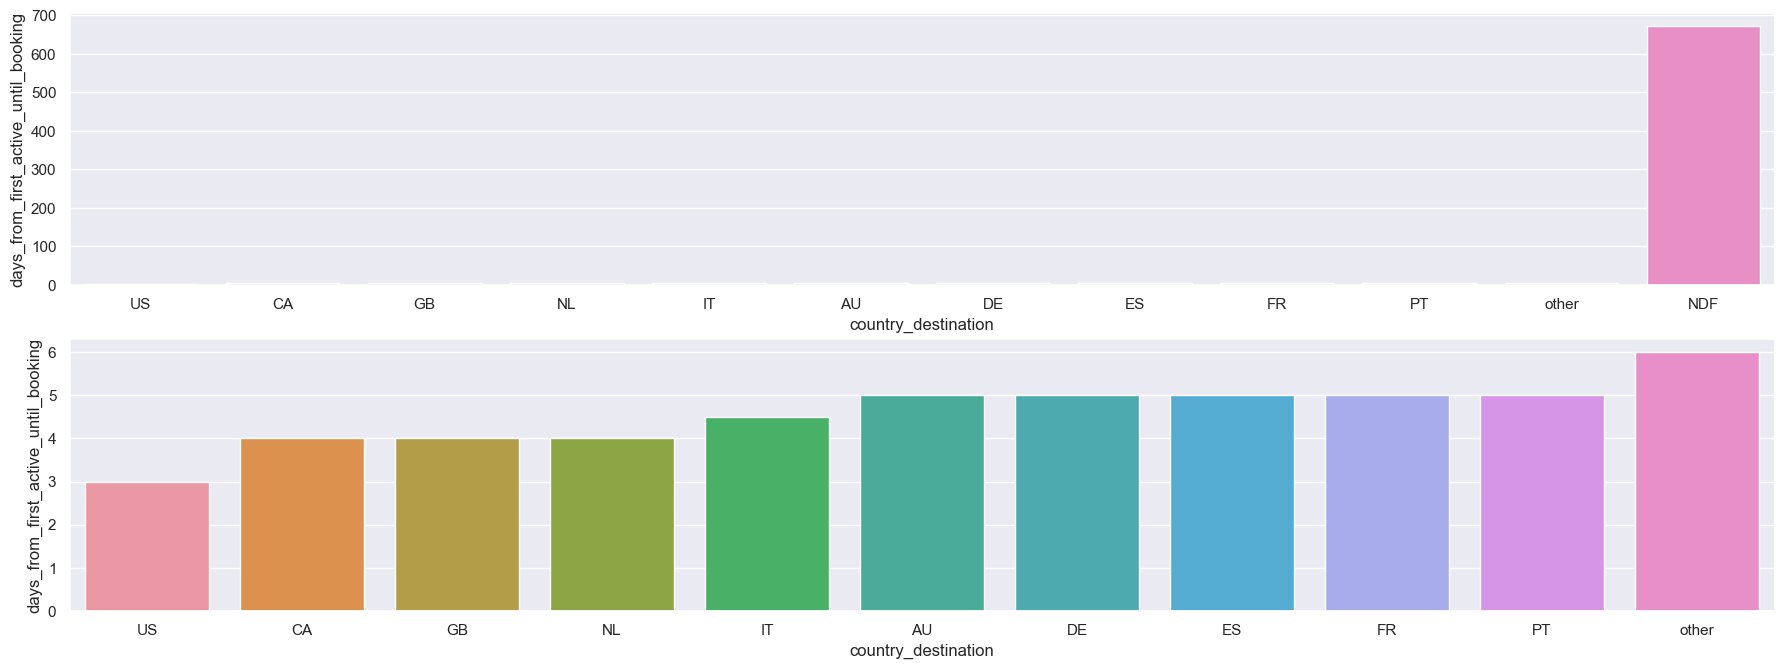

In [33]:
plt.subplot(3, 1, 1)
aux01 = df4[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', 
             data=aux01.sort_values('days_from_first_active_until_booking'))

# remove outlier
plt.subplot(3, 1, 2 )
aux02 = df4[df4['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', 
             data=aux02.sort_values('days_from_first_active_until_booking'));

### H2. Em todos os destinos, os usuários levam 3 dias, em média, para fazer o cadastro no site.
**Verdadeira.** Em todos os destinos, os usuários levam até 2 dias para finalizar o cadastro

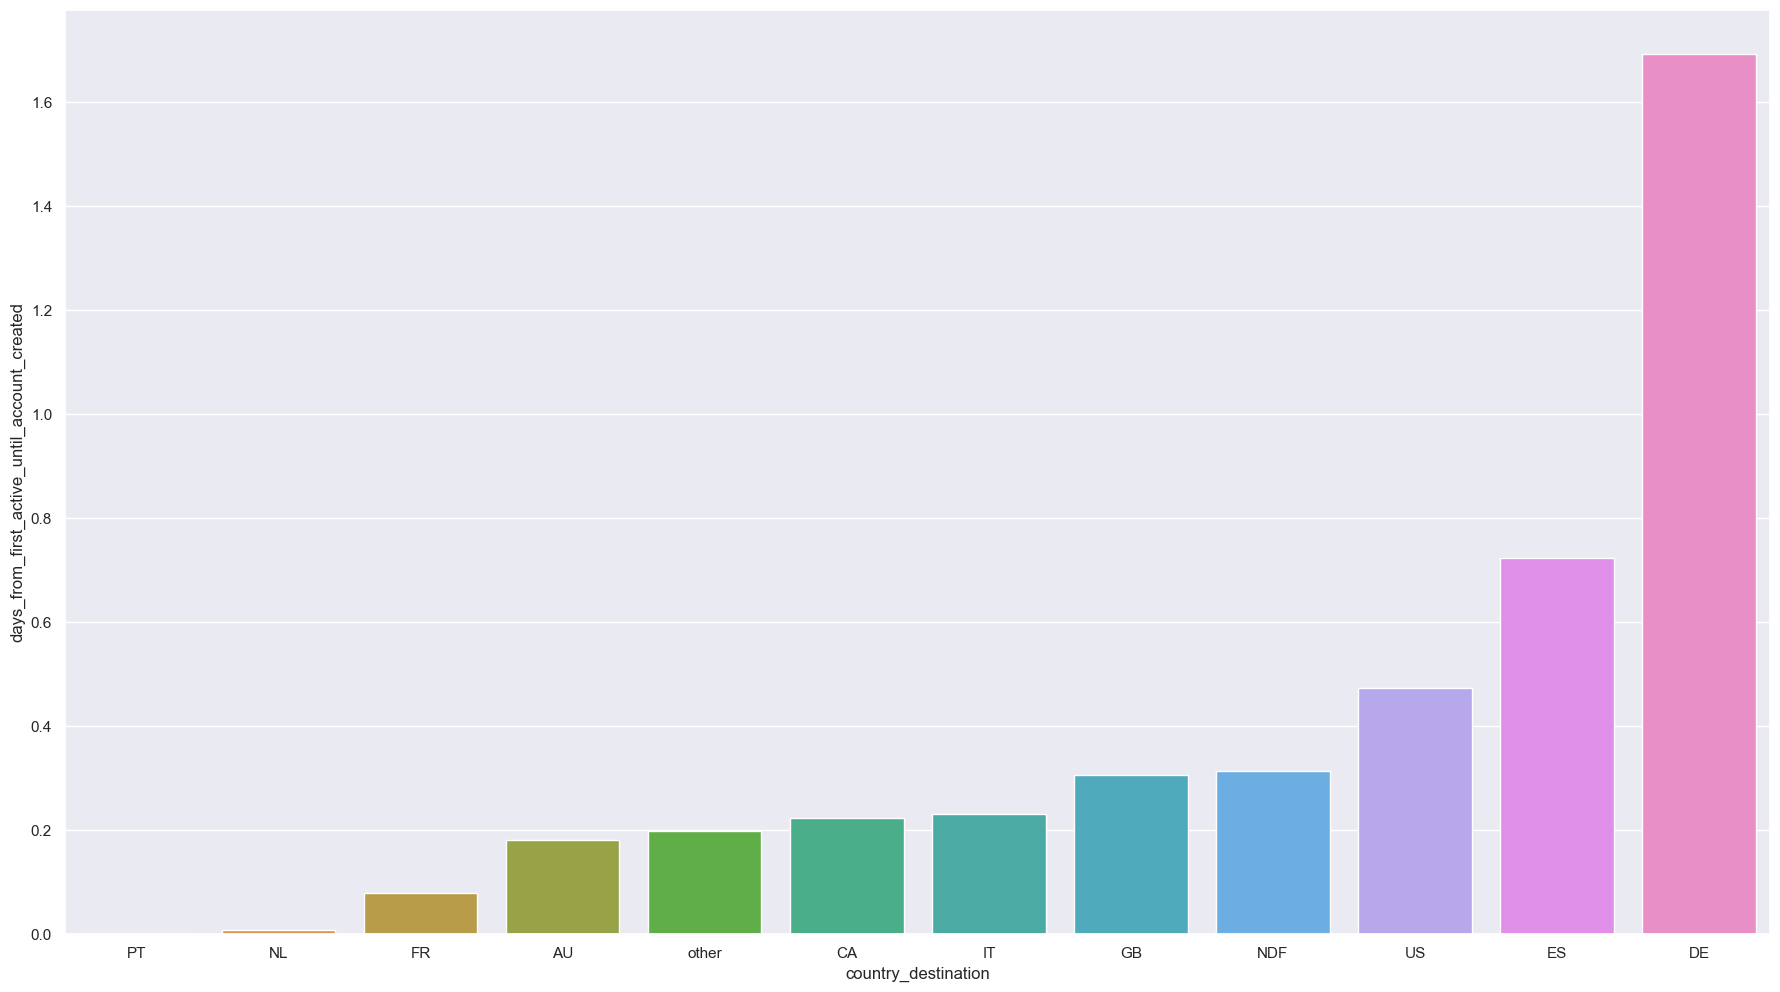

In [34]:
aux01 = df4[['days_from_first_active_until_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created', 
             data=aux01.sort_values('days_from_first_active_until_account_created'));

### H3. O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.
**False.** O Volume de reservas aumenta durante o verão entre os anos de 2010 até 2013.

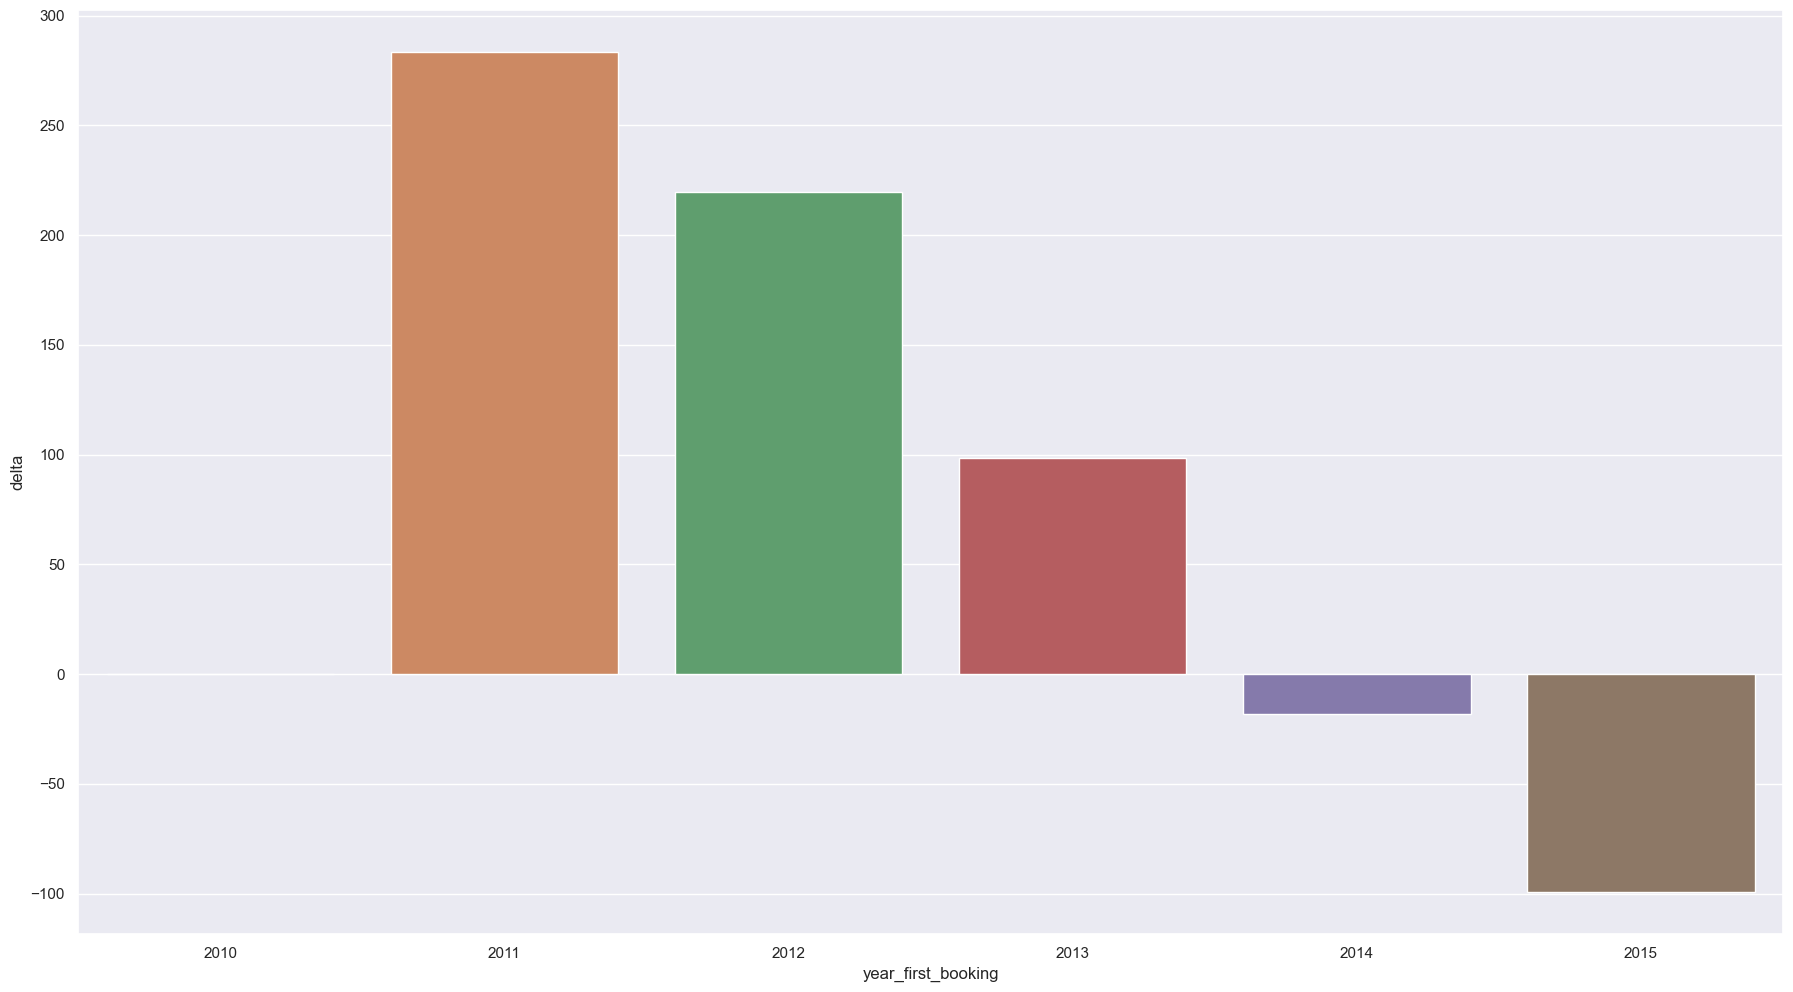

In [35]:
aux01 = df4[['year_first_booking', 'month_first_booking', 'country_destination']].\
                groupby(['year_first_booking', 'month_first_booking', 'country_destination']).\
                size().reset_index().rename(columns={0:'count'})

# select only summer
aux01 = aux01[(aux01['month_first_booking'].isin([6, 7, 8, 9])) & (aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()

aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)

sns.barplot( x='year_first_booking', y='delta', data=aux02);

#### H04. Usuários do sexo feminino fazem 10% mais reservas para países fora dos USA. 
#### H05. O canal de Marketing Google representa 40% das reservas para países fora dos USA. 
#### H06. O destino dos USA representam mais de 20% em todos os canais. 
#### H07. A idade média das pessoas é de 35 anos em todos os destinos. 
#### H08. A porcentagem de usuários que usam o site na lingua inglês-americano para reservar acomodações em qualquer destino é maior que 90% 
#### H09. O número de reservas do Airbnb é crescente ou decrescente ao longo dos anos? 
#### H10. O número de reservas do Airbnb é crescente ao longo dos anos.

# 5.0 Data Preparation

In [36]:
cols = ['days_from_first_active_until_booking',  'year_first_active',  'month_first_active', 'day_first_active',
    'day_of_week_first_active', 'week_of_year_first_active', 'month_first_booking', 'month_account_created',
    'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider',
    'first_browser', 'first_device_type'] # high correlation

df5 = df4.drop(cols, axis=1)

## 5.1 Balanced Dataset

In [37]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df5.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical
col_cat = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

# encoding
df5_dummy = pd.DataFrame(ohe.fit_transform(df5[ col_cat] ).toarray(), index=df5.index)

# join numerical and categorical
df51 = pd.concat([df5[col_num], df5_dummy], axis=1)


df5['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [39]:
# # create ratio of balanced variable
# ratio_balanced =  {'NDF': 54852,
#                    'US':  48057,
#                    'other': 6*7511,
#                    'FR': 12*3669,
#                    'IT': 20*2014,
#                    'GB': 26*1758,
#                    'ES': 26*1685,
#                    'CA': 40*1064,
#                    'DE': 48*841,
#                    'NL': 75*595,
#                    'AU': 95*433,
#                    'PT': 280*157}

# # define sampler
# smt = combine.SMOTETomek(sampling_strategy=ratio_balanced, random_state=42, n_jobs=-1)

# # apply sampler
# X_smt, y_smt = smt.fit_resample(df51, df5['country_destination'])

# y_smt.value_counts()

f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


NDF      54849
US       47419
GB       45641
other    44658
NL       44619
PT       43958
FR       43842
ES       43751
CA       42529
AU       41133
DE       40352
IT       40196
Name: country_destination, dtype: int64

In [40]:
# # numerical data
# df52 = X_smt[col_num]

# # categorical data
# df53 = X_smt.drop(col_num, axis=1)
# df54 = pd.DataFrame(ohe.inverse_transform(df53), columns=col_cat, index=df53.index)

# # join numerical categorical
# df55 = pd.concat([df52, df54], axis=1)
# df55['country_destination'] = y_smt

In [41]:
# # Saving Interim Data
# df55.to_parquet('../data/interim/df55_4.0.parquet')

df55 = pd.read_parquet('../data/interim/df55.parquet')

## 5.2 Encoding

In [42]:
# dummy variable
df51_dummy = pd.get_dummies(df55.drop(['country_destination'], axis=1))

# join id
df5 = pd.concat([df55[['country_destination']], df51_dummy], axis=1)

In [43]:
X = df5.drop('country_destination', axis=1)
y = df5['country_destination'].copy()

In [44]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6.0 Feature Selection

In [45]:
# cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # original dates

df6_train = X_train.copy()


df6_test = X_test.copy()

In [ ]:
# # Saving Interim Data
# df6_train.to_parquet('../data/interim/df6_train.parquet')
# df6_test.to_parquet('../data/interim/df6_test.parquet')

# pickle.dump(y_train, open('../data/interim/y_train.pkl', 'wb'))
# pickle.dump(y_test, open('../data/interim/y_test.pkl', 'wb'))

# 7.0 Machine Learning Modelling

In [46]:
x_train = df6_train.copy()
x_test = df6_test.copy()

## 7.1 Baseline Model

In [47]:
cd_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
cd_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=cd_list, weights=cd_weights, k=k_num)

### 7.1.1 Baseline Model Performance

Accuracy: 0.09575945210620133
Accuracy: 0.08474715322244857
Accuracy: 0.0018490603330523214
              precision    recall  f1-score   support

          AU       0.07      0.00      0.01      8227
          CA       0.07      0.01      0.01      8506
          DE       0.08      0.01      0.01      8070
          ES       0.08      0.01      0.02      8750
          FR       0.08      0.03      0.04      8768
          GB       0.09      0.02      0.03      9128
          IT       0.08      0.02      0.03      8039
         NDF       0.11      0.46      0.17     10970
          NL       0.07      0.00      0.01      8924
          PT       0.08      0.00      0.00      8792
          US       0.09      0.40      0.15      9484
       other       0.09      0.06      0.07      8932

    accuracy                           0.10    106590
   macro avg       0.08      0.08      0.05    106590
weighted avg       0.08      0.10      0.05    106590



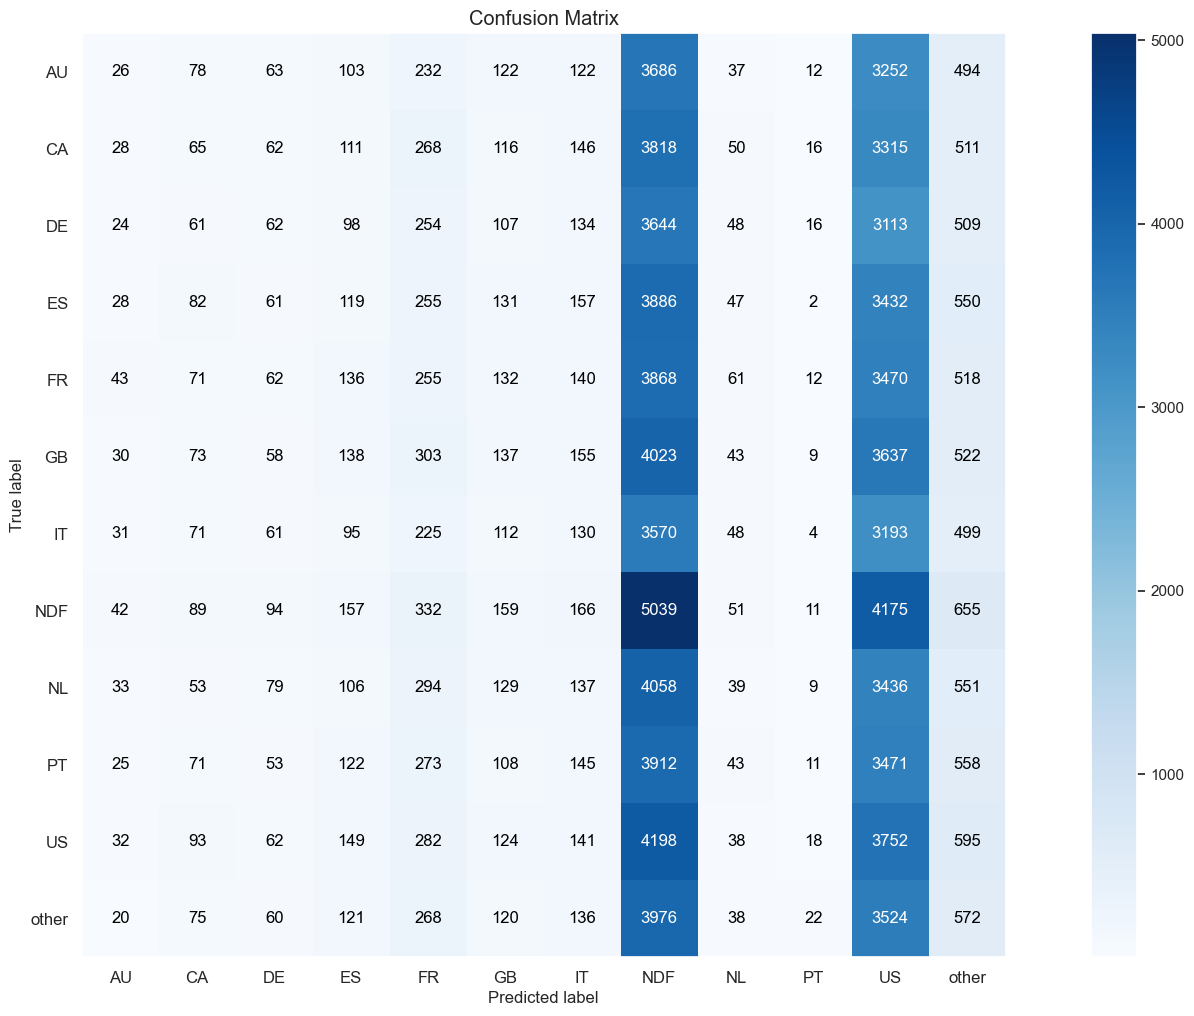

In [48]:
# Accuracy
acc_random = me.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

# Balanced Accuracy
balanced_acc_random = me.balanced_accuracy_score(y_test, yhat_random)
print(f'Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = me.cohen_kappa_score(y_test, yhat_random)
print(f'Accuracy: {kappa_random}')

# Classification report
print(me.classification_report( y_test, yhat_random ))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False);

## 7.2 Neural Network MLP

In [54]:
# Encoding variable response
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()


# model definition
model = ml.Sequential()
model.add(la.Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(la.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=50, verbose=False)

### 7.2.1 NN Performance

3331/3331 [==============================] - 2s 708us/step
Accuracy: 0.1938831034806267
Balanced Accuracy: 0.17420226619244497
Kappa Score: 0.11836558512103112


f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

          AU       0.21      0.08      0.12      8227
          CA       0.00      0.00      0.00      8506
          DE       0.00      0.00      0.00      8070
          ES       0.00      0.00      0.00      8750
          FR       0.00      0.00      0.00      8768
          GB       0.00      0.00      0.00      9128
          IT       0.00      0.00      0.00      8039
         NDF       1.00      1.00      1.00     10970
          NL       0.10      0.97      0.18      8924
          PT       0.00      0.00      0.00      8792
          US       0.13      0.04      0.06      9484
       other       0.00      0.00      0.00      8932

    accuracy                           0.19    106590
   macro avg       0.12      0.17      0.11    106590
weighted avg       0.14      0.19      0.13    106590



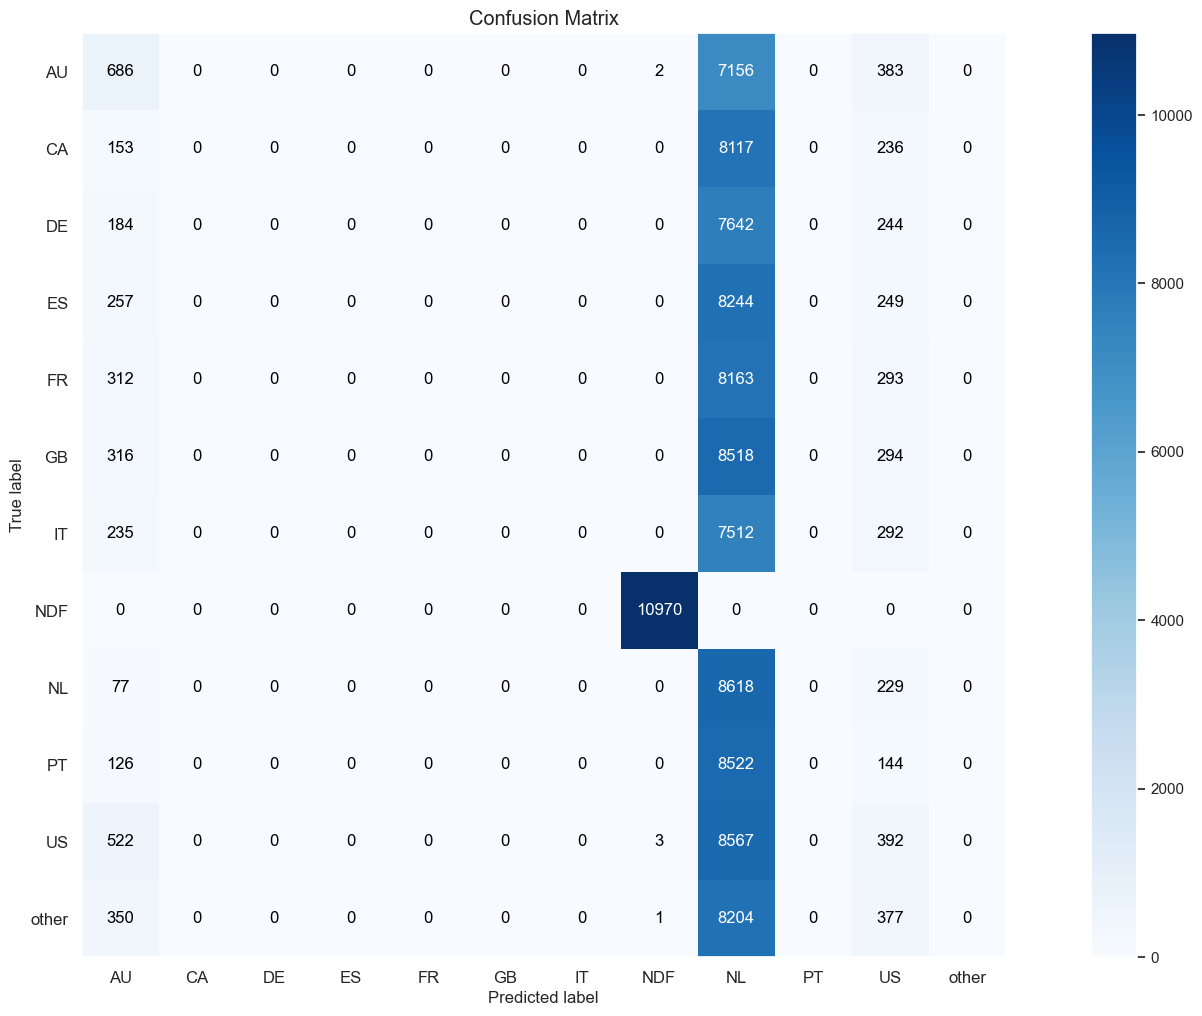

In [55]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]


# -------------------------- Metrics --------------------------
# Accuracy
acc_nn = me.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = me.balanced_accuracy_score(y_test, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = me.cohen_kappa_score(y_test, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification report
print(me.classification_report(y_test, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False);

### 7.1.2 NN Performance - Cross-Validation

In [ ]:
# # generate k-fold
# num_folds = 5
# kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# balanced_acc_list = []
# kappa_acc_list = []

# i = 1
# for train_ix, val_ix in kfold.split(x_train, y_train):
#     print(f'Fold Number: {i}/{num_folds}')
    
#     # get fold
#     x_train_fold = x_train.iloc[train_ix]
#     y_train_fold = y_train.iloc[train_ix]
    
#     x_val_fold = x_train.iloc[val_ix]
#     y_val_fold = y_train.iloc[val_ix]
    
#     # target hot-encoding
#     ohe = pp.OneHotEncoder()
#     y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

#     # model definition
#     model = ml.Sequential()
#     model.add(la.Dense(256, input_dim=x_train.shape[1], activation='relu'))
#     model.add(la.Dense(12, activation='softmax'))

#     # compile model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # training model
#     model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

#     # prediction
#     pred_nn = model.predict(x_val_fold)
#     yhat_nn = ohe.inverse_transform(pred_nn)
    
#     # prepare data
#     y_test_nn = y_val_fold.to_numpy()
#     yhat_nn = yhat_nn.reshape(1, -1)[0]

#     # metrics
#     ## Balanced Accuracy 
#     balanced_acc_nn = me.balanced_accuracy_score(y_test_nn, yhat_nn)
#     balanced_acc_list.append(balanced_acc_nn)
    
#     ## Kappa Metrics
#     kappa_acc_nn = me.cohen_kappa_score(y_test_nn, yhat_nn)
#     kappa_acc_list.append(kappa_acc_nn)
    
#     i += 1

In [ ]:
# print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} +/- {np.std(balanced_acc_list)}')
# print(f'Avg Kappa: {np.mean(kappa_acc_list)} +/- {np.std(kappa_acc_list)}')

## 7.3 LGBM

In [52]:
lgbm_model = LGBMClassifier(objective='multiclass', num_class=12, metric='multi_logloss')

lgbm_model.fit(x_train, y_train)

LGBMClassifier(metric='multi_logloss', num_class=12, objective='multiclass')

### 7.3.1 LGBM Performance

Accuracy: 0.6235012665353222
Balanced Accuracy: 0.6170460614935896
Kappa Score: 0.5889574085239884
              precision    recall  f1-score   support

          AU       0.62      0.85      0.72      8227
          CA       0.57      0.61      0.59      8506
          DE       0.64      0.69      0.67      8070
          ES       0.53      0.51      0.52      8750
          FR       0.49      0.33      0.40      8768
          GB       0.62      0.44      0.52      9128
          IT       0.63      0.41      0.50      8039
         NDF       1.00      1.00      1.00     10970
          NL       0.63      0.78      0.70      8924
          PT       0.77      0.97      0.85      8792
          US       0.40      0.57      0.47      9484
       other       0.45      0.24      0.31      8932

    accuracy                           0.62    106590
   macro avg       0.61      0.62      0.60    106590
weighted avg       0.62      0.62      0.61    106590



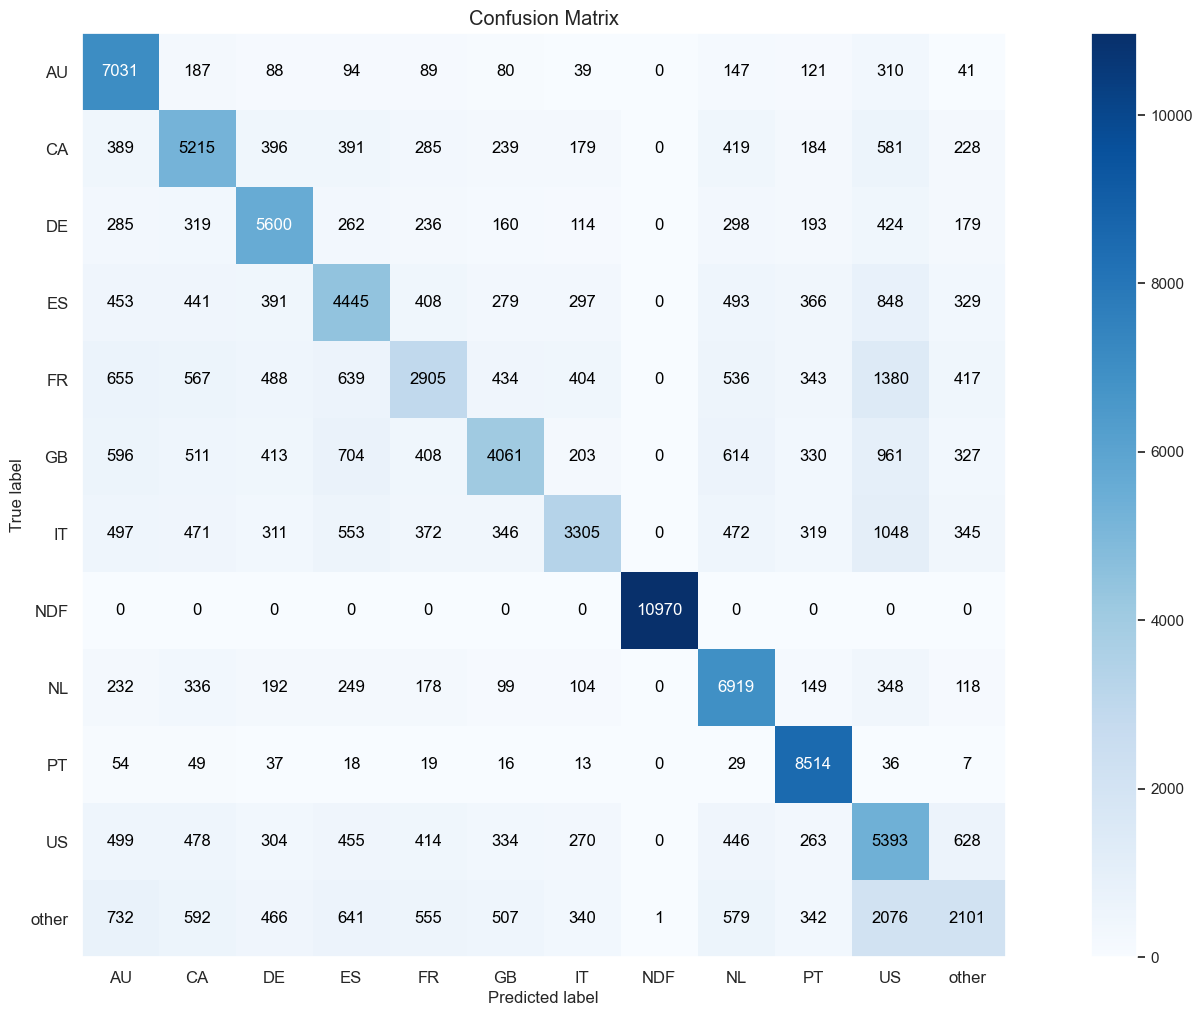

In [53]:
# prediction
yhat_lgbm = lgbm_model.predict(x_test)

# -------------------------- Metrics --------------------------
# Accuracy
acc_lgbm = me.accuracy_score(y_test, yhat_lgbm)
print(f'Accuracy: {acc_lgbm}')

# Balanced Accuracy
balanced_acc_lgbm = me.balanced_accuracy_score(y_test, yhat_lgbm)
print(f'Balanced Accuracy: {balanced_acc_lgbm}')

# Kappa Metrics
kappa_lgbm = me.cohen_kappa_score(y_test, yhat_lgbm)
print(f'Kappa Score: {kappa_lgbm}')

# Classification report
print(me.classification_report(y_test, yhat_lgbm))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_lgbm, normalize=False);